<a href="https://colab.research.google.com/github/buck06191/prototyping-notebooks/blob/main/autoencode_spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, pairwise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow_probability as tfp


In [ ]:
# Set constants

N_WAVELENGTHS = 750

# Generate spectral data

Create a set of random distributions that are spaced out 

In [ ]:
rng = np.random.default_rng(12345)
def generate_clean_spectra(n_spectra, bins = 500):
    n_features = bins * 10
    alphas = rng.uniform(low=0.5, high=5, size=10)
    raw_samples = tf.random.gamma([n_spectra // 10, n_features], alphas)
    samples = tf.transpose(tf.reshape(raw_samples, [n_spectra, n_features]))
    edges = np.linspace(0, 25, bins + 1, dtype=np.float32)

    # Scale to be bwteen 0 and 1
    spectra = tf.transpose(tfp.stats.histogram(samples, edges, axis=0))    
    maximums = tf.reduce_max(spectra)
    scaled_spectra = spectra/maximums

    return scaled_spectra #, samples

def add_noise_to_samples(samples, noise_factor = 0.2):
    return samples + noise_factor * tf.random.normal(shape=samples.shape, dtype=samples.dtype)

In [ ]:
spectra = generate_clean_spectra(10000, N_WAVELENGTHS)
noisy_samples = add_noise_to_samples(spectra, .2)

print(spectra.shape, noisy_samples.shape)

(10000, 750) (10000, 750)


Confirm that the distributions are varied by plotting a sample of them

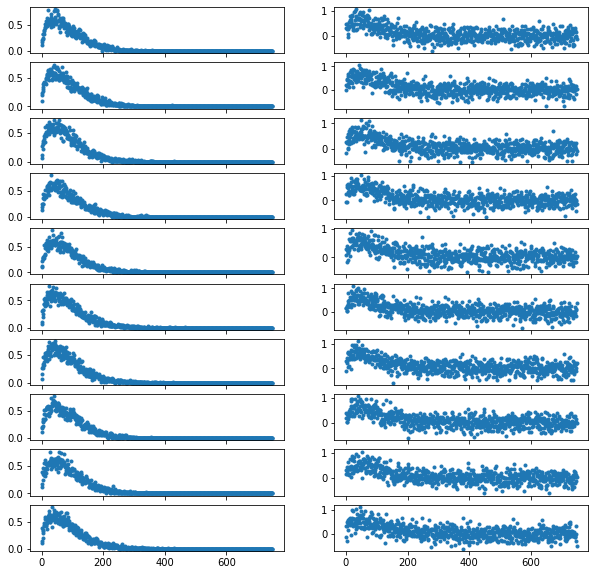

In [ ]:
samp_size = 10
fig, axes = plt.subplots(samp_size, 2, sharex=True, figsize=(10,10))
for i in range(samp_size):
    axes[i, 0].plot(spectra[i, :], '.')
    axes[i, 1].plot(noisy_samples[i, :], '.')

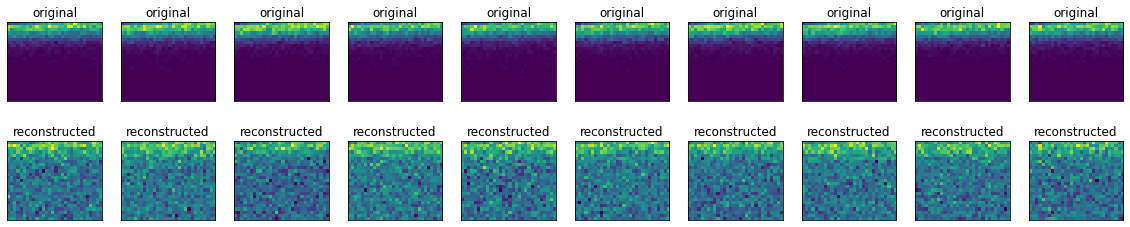

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    img = tf.reshape(spectra[i ,:], [25,30]).numpy().astype('float32') / 255.
    plt.imshow(img)
    plt.title("original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    img = tf.reshape(noisy_samples[i,:], [25,30]).numpy().astype('float32') / 255.
    plt.imshow(img)
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Autoencoder

Define an autoencoder with two Dense layers: an encoder, which compresses the spectra into a 64 dimensional latent vector, and a decoder, that reconstructs the original spectra from the latent space.

To define your model, use the Keras Model Subclassing API.

In [ ]:
train_size = int(spectra.shape[0] * 0.9)
x_train, x_test = tf.split(spectra, [train_size, spectra.shape[0] - train_size])

In [ ]:
latent_dim = 32 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        # layers.Dense(latent_dim * 2, activation='relu'),
        layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
        # layers.Dense(latent_dim * 2, activation='sigmoid'),

        layers.Dense(N_WAVELENGTHS, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [ ]:
# autoencoder.compile(optimizer='adam', loss=losses.KLDivergence())

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
282/282 [==============================] - 6s 3ms/step - loss: 0.0166 - val_loss: 0.0011
Epoch 2/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 5/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 7/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010

In [ ]:
encoded_spectra = autoencoder.encoder(x_test).numpy()
decoded_spectra = autoencoder.decoder(encoded_spectra).numpy()

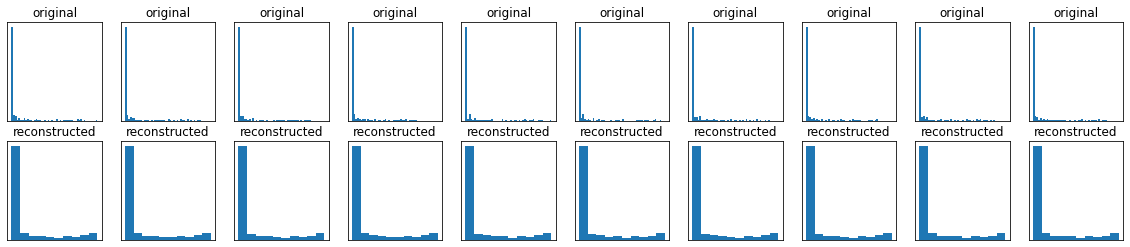

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.hist(x_test[i,:], 50)
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.hist(decoded_spectra[i, :])
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

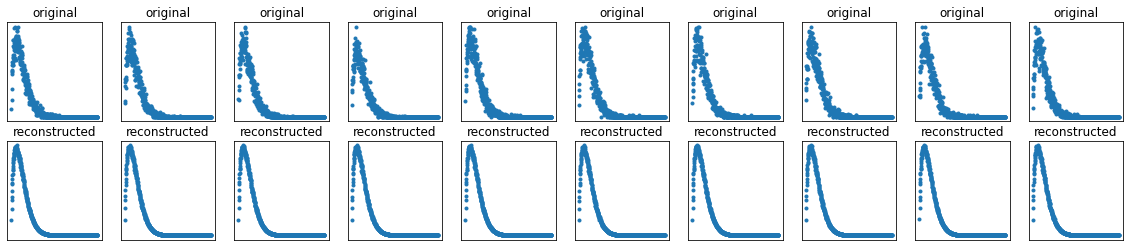

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.plot(x_test[i,:], '.')
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(decoded_spectra[i, :], '.')
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

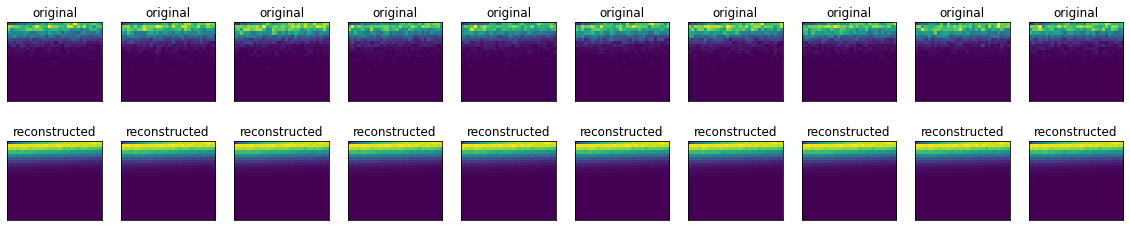

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    img = tf.reshape(spectra[i ,:], [25,30]).numpy().astype('float32') / 255.
    plt.imshow(img)
    plt.title("original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    img = tf.reshape(decoded_spectra[i,:], [25,30]).numpy().astype('float32') / 255.
    plt.imshow(img)
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Noisy Data


In [ ]:
train_size = int(noisy_samples.shape[0] * 0.9)
x_train_noisy, x_test_noisy = tf.split(noisy_samples, [train_size, noisy_samples.shape[0] - train_size])

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
282/282 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 2/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 3/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 5/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 7/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/10
282/282 [==============================] - 1s 4ms/step - loss: 0.0010 - val_loss: 0.0010

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

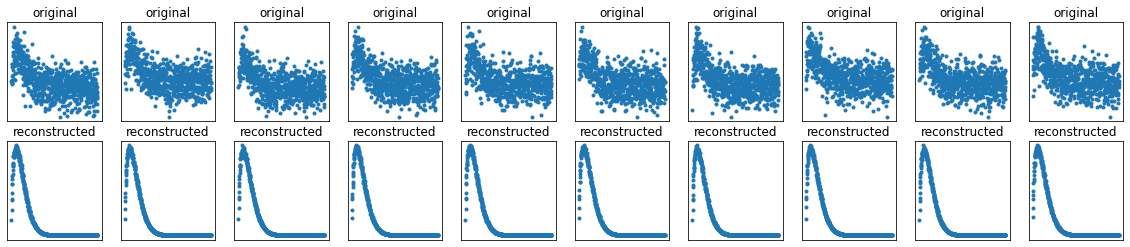

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.plot(x_test_noisy[i,:], '.')
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(decoded_imgs[i, :], '.')
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()